# Optional imports

In [1]:
%%capture
!pip install --upgrade --no-cache-dir gdown

In [2]:
%%capture
!pip install transformers
from transformers import BertTokenizer, BertModel

In [10]:
%%capture
model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

def bert_encode(t):
  input_ids = bert_tokenizer.encode(t)
  #print(bert_tokenizer.convert_ids_to_tokens(input_ids))
  outputs = bert_model(torch.tensor([input_ids]))[0]
  return outputs[0,0].tolist()

# Source code

In [11]:
import seaborn as sns
import pandas as pd
import numpy as np
from random import random
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import kurtosis
from ast import literal_eval
import seaborn as sns
from ast import literal_eval
from sklearn.metrics import *
from tqdm.notebook import tqdm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import scipy
from sklearn.metrics import *
import torch

In [12]:
# DFU updated with normalisation
def dfu(input_data, histogram_input=True, normalised=True):
  """ The Distance From Unimodality measure
  :param: input_data: the data, by default the relative frequencies of ratings
  :param: histogram_input: False to compute rel. frequencies (ratings as input)
  :return: the DFU score
  """
  hist = input_data if histogram_input else to_hist(input_data)
  max_value = max(hist)
  pos_max = np.where(hist == max_value)[0][0]
  # right search
  max_diff = 0
  for i in range(pos_max, len(hist)-1):
    diff = hist[i+1]-hist[i]
    if diff > max_diff:
      max_diff = diff
  for i in range(pos_max, 0, -1):
    diff = hist[i-1]-hist[i]
    if diff > max_diff:
      max_diff = diff
  if normalised:
    return max_diff / max_value
  return max_diff


def to_hist(scores, bins_num=3, normed=True):
  """ Creating a normalised histogram
  :param: scores: the ratings (not necessarily discrete)
  :param: bins_num: the number of bins to create
  :param: normed: whether to normalise or not, by default true
  :return: the histogram
  """
  # not keeping the values order when bins are not created
  counts, bins = np.histogram(a=scores, bins=bins_num)
  counts_normed = counts/counts.sum()
  return counts_normed if normed else counts

SCALE10 = list(range(1,11))


def pdf(scores, scale=SCALE10):
  """ The relative frequencies of ordinal ratings.
  :param: scores: the ratings
  :param: scale: the rating categories, by default 10-point scale
  :return: the relative frequencies
  """
  # to be used when no bins are created
  freqs = Counter(scores)
  return np.array([freqs[s]/len(scores) for s in scale])


def cpdf(scores, scale=SCALE10):
  """ Cumulative relative frequencies
  :param: scores: the ratings
  :param: scale: the rating categories, by default 10-point scale
  :return: the cumultive relative frequencies
  """
  return np.cumsum(pdf(scores, scale))

In [13]:
x,scale = (1,1,2, 4,4,4), range(1,6)
pdf(x, scale=scale)

array([0.33333333, 0.16666667, 0.        , 0.5       , 0.        ])

In [14]:
class UnimodalLearner:

    def __init__(self, train, dev, test, tox_threshold=0, text_col="text", scores_col="scores", scale=(-2,-1,0,1), algorithm=LogisticRegression):
        # loading the data, should comprise a column text, one with scores, and one with toxicity
        self.train = train
        self.test = test
        self.dev = dev
        self.tox_threshold = tox_threshold
        # binarized toxicity probability (lower is toxic)
        self.toxicity_func = lambda scores: np.round(np.mean([s<self.tox_threshold for s in scores]))
        # unimodality classification: if DFU is above T, then set to K+1, otherwise classify according the toxicity label
        self.labeller = lambda dfu, scores, T=0: "k+1" if dfu>T else "civil" if self.toxicity_func(scores)==0 else "toxic"
        self.scores_col = scores_col
        self.text_col = text_col
        for dataset in (self.train, self.dev, self.test):
            assert self.scores_col in dataset.columns
            dataset["HIST"] = dataset[self.scores_col].apply(lambda x: pdf(x, scale))
            dataset["DFU"] = dataset.HIST.apply(dfu) # --> changing this yields a baseline
            dataset["toxicity"] = dataset[self.scores_col].apply(self.toxicity_func)
        self.weights = {c:train.toxicity.value_counts()[c] for c in (0, 1)}
        self.thresholds = (0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0)
        self.baseline_results = {"unimodal":{}, "multimodal":{}}
        self.algorithm = algorithm

    def to_np(self, dataset):
      return np.concatenate(dataset.to_numpy()).reshape(dataset.shape[0], 768) # <-- assuming BERT weights

    def pvalue(self, th=0, ssize=100, reps=range(20), averaging="macro"):
      '''
      The class reduction hypothesis: Reduce the K+1 class and compare to the
      K-class baseline
      :param th: the unimodality threshold, above this the item is said K+1
      :param ssize: the sample size
      :param reps: the repetitions of the sampling
      :param averaging: macro/micro averaging of F1
      :return: P value --> lower than 5% means the baseline lost
      '''
      model_results, baseline_results = [], []
      for _ in reps:
        e = self.test[self.test.DFU == 0].sample(ssize)
        probs = self.models[th].predict_proba(self.to_np(e["bert"]))[:, ::2] # ignoring K+1
        preds = np.argmax(probs, 1) # toxic is lower
        baseline = self.baseline.predict(self.to_np(e["bert"]))
        model_results.append(f1_score(e.toxicity.values, preds, average=averaging))
        baseline_results.append(f1_score(e.toxicity.values, baseline, average=averaging))
      statistic = scipy.stats.mannwhitneyu(baseline_results, model_results, alternative="less")
      return statistic, baseline_results, model_results


    def baseline_building(self):
        self.baseline=self.algorithm(random_state=2046, class_weight=self.weights)
        if self.algorithm is LogisticRegression:
          self.baseline.max_iter = 100000
        self.baseline.fit(self.to_np(self.train.bert), self.train.toxicity.values)
        for name, e in (("unimodal", self.dev[self.dev.DFU==0]), ("multimodal", self.dev[self.dev.DFU>0])):
            X_test = self.to_np(e["bert"])
            preds = self.baseline.predict(X_test)
            probs = self.baseline.predict_proba(X_test)
            self.baseline_results[name]["P"] = precision_score(e.toxicity.values, preds) # for toxic class
            self.baseline_results[name]["R"] = recall_score(e.toxicity.values, preds) # for toxic class
            self.baseline_results[name]["F1"] = f1_score(e.toxicity.values, preds, average='macro')
            self.baseline_results[name]["F1m"] = f1_score(e.toxicity.values, preds, average='micro')
            self.baseline_results[name]["AP"] = average_precision_score(e.toxicity.values, probs[:, 1])
            self.baseline_results[name]["AUC"] = roc_auc_score(e.toxicity.values, probs[:, 1])
            self.baseline_results[name]["support"] = len(preds)



    def baseline_tuning(self):
        self.baseline=self.algorithm(random_state=2046, class_weight=self.weights)
        if self.algorithm is LogisticRegression:
          self.baseline.max_iter = 100000
        self.baseline.fit(self.to_np(self.train.bert), self.train.toxicity.values)
        probs = self.baseline.predict_proba(self.to_np(self.dev["bert"]))
        gold = self.dev.toxicity.values
        scores = {}
        for thr in (.1, .2, .3, .4, .5, .6, .7, .8, .9):
          lbls = probs[:,1] > thr
          scores[thr] = f1_score(gold, lbls, average='macro')
        return scores


    def reduced_baseline_building(self):
        self.baseline=self.algorithm(random_state=2046, class_weight=self.weights)
        if self.algorithm is LogisticRegression:
          self.baseline.max_iter = 1000000
        train = self.train[self.train.DFU==0]
        print(f'Removed {self.train.shape[0]-train.shape[0]} instances from the {self.train.shape[0]} ones...')
        self.baseline.fit(self.to_np(train.bert), train.toxicity.values)
        preds = self.baseline.predict(self.to_np(self.test["bert"]))
        gold = self.test.toxicity.values
        return classification_report(gold, preds)



    def hypothesis_building(self, algorithm=LogisticRegression):
        self.models = {}
        for th in self.thresholds:
            self.train["target"] = self.train.apply(lambda x: self.labeller(x.DFU, x[self.scores_col], th), 1)
            self.dev["target"] = self.dev.apply(lambda x: self.labeller(x.DFU, x[self.scores_col], th), 1)
            self.test["target"] = self.test.apply(lambda x: self.labeller(x.DFU, x[self.scores_col], th), 1)

            # update the class weights for each threshold
            weight = self.train.target.value_counts()
            weights = {c:weight[c] for c in ("civil", "k+1", "toxic")}
            model = self.algorithm(random_state=2046, class_weight=weights)
            if self.algorithm is LogisticRegression:
              model.max_iter = 100000

            model.fit(self.to_np(self.train.bert), self.train.target.values)
            self.models[th] = model

    def hypothesis_testing(self, ssize=500, iterations=10, unimodality=True):
        '''
        F1 of the baseline and the K+1 model per unimodality threshold
        '''
        y = []; method_name=[]; x=[];
        for th in self.thresholds:
            for _ in range(iterations):
                condition = (self.dev.DFU == 0) if unimodality else (self.dev.DFU>0)
                e = self.dev[condition].sample(ssize)
                probs = self.models[th].predict_proba(self.to_np(e["bert"]))
                probs = probs[:, ::2] # ignoring K+1
                preds = np.argmax(probs, 1)
                y.append(precision_score(e.toxicity.values, preds)); method_name.append("Precision"); x.append(th)
                y.append(recall_score(e.toxicity.values, preds)); method_name.append("Recall");x.append(th)
                y.append(f1_score(e.toxicity.values, preds, average='macro')); method_name.append("F1-macro");x.append(th)
        results = pd.DataFrame({"Score":y, "T":x, "Measure":method_name})
        ax = sns.lineplot(data=results, x="T", y="Score", hue="Measure")
        sns.despine(left=True, bottom=True);
        ax.plot(results["T"].values, [self.baseline_results['unimodal' if unimodality else 'multimodal']["F1"]]*results.shape[0], "g*");
        return ax

# Attitudes

In [14]:
#@title [Optional] Develop the data
# read the attitudes dataset by embedding the text from scratch
# RECALL TO UPLOAD THE DATA
sap = pd.read_csv("attitudes.csv")
g = sap.groupby("tweet")
attitudes = pd.DataFrame()
for col in ['toyou', 'toany', 'annotatorMinority', 'annotatorPolitics', 'traditionalism', 'annotatorRace', 'annotatorAge', 'annotatorGender', 'freeSpeech', 'harmHateSpeech', 'intent', 'lingPurism', 'racism', 'racist']:
    attitudes[col] = g[col].apply(list)
attitudes.reset_index(inplace=True)

# extract BERT features
embedded = []
for t in tqdm(attitudes.tweet.values):
  try: embedded.append(bert_encode(t))
  except: embedded.append(None)
attitudes.insert(4, "bert", embedded)
attitudes.to_pickle("attitudes_embedded.csv")

In [15]:
#@title Download
%%capture
# RECALL TO UPLOAD THE DATA
attitudes = pd.read_pickle("attitudes_embedded.csv")
scale = list(range(1,6))
attitudes["scores"] = attitudes.toyou.apply(lambda x: [max(scale)+1-i for i in x]) # 1 is toxic
attitudes["HIST"] = attitudes.scores.apply(lambda x: pdf(x, scale))
attitudes["DFU"] = attitudes.HIST.apply(dfu) # scores.apply(np.var) / lambda x: random.random()
att_train, att_test = train_test_split(attitudes, test_size=0.25, random_state=2046, shuffle=True)
att_train, att_dev = train_test_split(att_train, test_size=att_test.shape[0], random_state=2046, shuffle=True)

## Unimodal learning

In [16]:
# using logistic regression as the baseline
xattds = UnimodalLearner(att_train, att_dev, att_test, tox_threshold=2, text_col="tweet", scale=scale)
xattds.baseline_building()
xattds.hypothesis_building()
xattds.baseline_results

{'unimodal': {'P': 0.45,
  'R': 0.391304347826087,
  'F1': 0.6167097329888027,
  'F1m': 0.7191011235955056,
  'AP': 0.49169846656832994,
  'AUC': 0.7450592885375494,
  'support': 89},
 'multimodal': {'P': 0.5,
  'R': 0.42857142857142855,
  'F1': 0.6225218080888184,
  'F1m': 0.6911764705882353,
  'AP': 0.6037791851139998,
  'AUC': 0.7325227963525835,
  'support': 68}}

In [ ]:
xattds.baseline_tuning()

{0.1: 0.658824640967498,
 0.2: 0.6409769863280299,
 0.3: 0.6526548672566372,
 0.4: 0.6581599068307256,
 0.5: 0.6203742640874684,
 0.6: 0.6247283789656671,
 0.7: 0.6058577405857741,
 0.8: 0.6162678337975331,
 0.9: 0.6245815399330463}

In [ ]:
# classification report for the (default) binary baseline
preds = xattds.baseline.predict(xattds.to_np(xattds.test["bert"]))
gold = xattds.test.toxicity.values
print(classification_report(gold, preds))

              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88       122
         1.0       0.58      0.40      0.47        35

    accuracy                           0.80       157
   macro avg       0.71      0.66      0.68       157
weighted avg       0.78      0.80      0.79       157



In [ ]:
# binary classification report by removing high nDFU posts
reduced_train = xattds.train[xattds.train.DFU==0]
xattds.baseline.fit(xattds.to_np(reduced_train.bert), reduced_train.toxicity.values)
preds = xattds.baseline.predict(xattds.to_np(xattds.test["bert"]))
gold = xattds.test.toxicity.values
print(classification_report(gold, preds))

              precision    recall  f1-score   support

         0.0       0.86      0.87      0.87       122
         1.0       0.53      0.51      0.52        35

    accuracy                           0.79       157
   macro avg       0.70      0.69      0.69       157
weighted avg       0.79      0.79      0.79       157



In [ ]:
# using logistic regression as the baseline
xattds = UnimodalLearner(att_train, att_dev, att_test, tox_threshold=2, text_col="tweet", scale=scale)
xattds.baseline_building()
xattds.hypothesis_building()
xattds.baseline_results

{'unimodal': {'P': 0.45,
  'R': 0.391304347826087,
  'F1': 0.6167097329888027,
  'F1m': 0.7191011235955056,
  'AP': 0.49169846656832994,
  'AUC': 0.7450592885375494},
 'multimodal': {'P': 0.5,
  'R': 0.42857142857142855,
  'F1': 0.6225218080888184,
  'F1m': 0.6911764705882353,
  'AP': 0.6037791851139998,
  'AUC': 0.7325227963525835}}

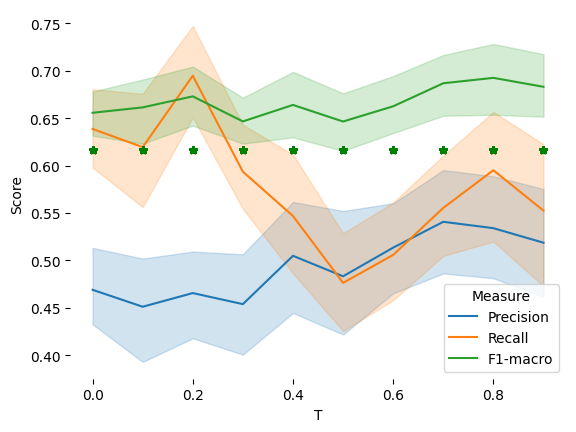

In [ ]:
ax = xattds.hypothesis_testing(ssize=50)
ax.get_figure().savefig("attitudes_unimodal-eval.pdf", format="PDF", dpi=300)

In [ ]:
p, b, m = xattds.pvalue(th=0.5, ssize=50)
print(p)
print(f"{np.mean(m):.2f} compared to the baseline: {np.mean(b):.2f}")

MannwhitneyuResult(statistic=85.0, pvalue=0.000971417761685664)
0.65 compared to the baseline: 0.60


AUC: 0.649
              precision    recall  f1-score   support

       civil       0.47      0.52      0.49        60
         k+1       0.52      0.56      0.54        71
       toxic       0.50      0.27      0.35        26

    accuracy                           0.50       157
   macro avg       0.50      0.45      0.46       157
weighted avg       0.50      0.50      0.49       157



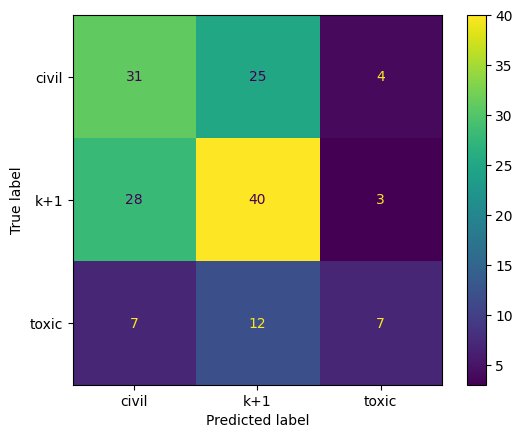

In [ ]:
# 3-class assessment
th = 0.
target = xattds.test.apply(lambda x: xattds.labeller(x.DFU, x.scores, th), 1)
prediction = xattds.models[th].predict(xattds.to_np(xattds.test.bert))
predict_probs = xattds.models[th].predict_proba(xattds.to_np(xattds.test.bert))
print(f"AUC: {roc_auc_score(target, predict_probs, average='macro', multi_class='ovr'):.3f}")
print(classification_report(target, prediction))
cm = ConfusionMatrixDisplay.from_predictions(target, prediction);
cm.figure_.savefig("attitudes-k+1.pdf", format="PDF", dpi=300)

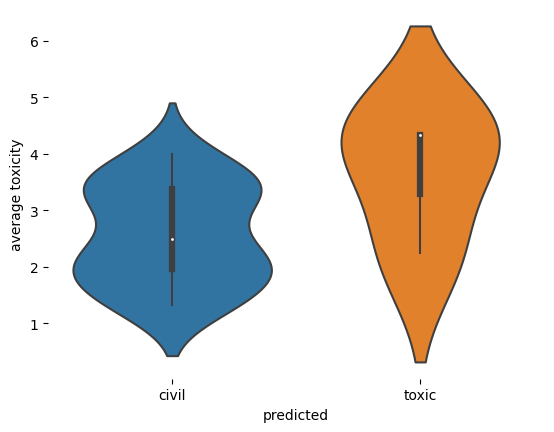

In [ ]:
err1 = xattds.test[(target=="k+1")&(prediction=="civil")] # +1 said civil
err2 = xattds.test[(target=="k+1")&(prediction=="toxic")] # +1 said toxic
ax = sns.violinplot(data=pd.DataFrame({"average toxicity":(6-err1.scores.apply(np.mean)).to_list()+(6-err2.scores.apply(np.mean)).to_list(),
                                       "predicted": ["civil"]*err1.shape[0] + ["toxic"]*err2.shape[0]
                                       }), y="average toxicity", x="predicted");
sns.despine(left=True, bottom=True) # smaller is more toxic
ax.get_figure().savefig("attitudes_violins.pdf", format="PDF", dpi=300)

# XMachina


## Dataset development

In [ ]:
%%capture
# RECALL TO UPLOAD THE DATA
# RECALL TO UPLOAD THE DATA
# RECALL TO UPLOAD THE DATA

xmachina_annots = pd.read_csv("toxicity_annotations.tsv", sep="\t")
xmachina_texts = pd.read_csv("toxicity_annotated_comments.tsv", sep="\t")
xmachina_demo = pd.read_csv("toxicity_worker_demographics.tsv", sep="\t")

In [ ]:
# summarise the annotations based on the texts
merged = pd.merge(xmachina_texts, xmachina_annots, on = 'rev_id')
merged = pd.merge(merged, xmachina_demo, on = 'worker_id')

# unroll the annotations
g = merged.groupby("comment")
xmachina = pd.DataFrame()
for col in ["toxicity", "toxicity_score", "gender", "age_group", "education"]:
    xmachina[col] = g[col].apply(list)

xmachina.reset_index(inplace=True)
xmachina.sample()

,comment,toxicity,toxicity_score,gender,age_group,education
92258,NEWLINE_TOKENNEWLINE_TOKENThe debunkers (prete...,"[0, 0, 0, 0, 0, 1, 0, 0]","[1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0, 0.0]","[male, male, male, female, male, female, femal...","[30-45, 18-30, 18-30, 18-30, Under 18, 18-30, ...","[masters, hs, hs, bachelors, hs, bachelors, ba..."


In [ ]:
# cleaning redundant tokens
xmachina.comment = xmachina.comment.apply(lambda x: x.replace("NEWLINE_TOKEN", "\n"))
# filtering out ~20% of lengthy texts
xmachina = xmachina[xmachina.comment.apply(len)<500]

In [ ]:
xmachina["HIST"] = xmachina.toxicity_score.apply(lambda x: pdf(x, (-2, -1, 0, 1, 2)))
xmachina["DFU"] = xmachina.HIST.apply(dfu)

In [ ]:
xmachina_mm = xmachina[xmachina.DFU>0]
xmachina_um = xmachina[xmachina.DFU==0]

In [ ]:
uninot = xmachina_um[xmachina_um.toxicity_score.apply(np.mean)>=0].sample(1000) #uni-not
unitox = xmachina_um[xmachina_um.toxicity_score.apply(np.mean)<0].sample(1000) #uni-tox
multinot = xmachina_mm[xmachina_mm.toxicity_score.apply(np.mean)>=0].sample(1000) #multi-not
multitox = xmachina_mm[xmachina_mm.toxicity_score.apply(np.mean)<0].sample(1000) #multi-tox

In [ ]:
xmachina_sampled = pd.concat([uninot, unitox, multinot, multitox])

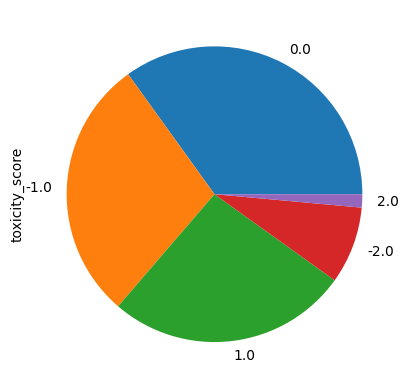

In [ ]:
xmachina_sampled.toxicity_score.explode().value_counts().plot.pie();

In [ ]:
# extract BERT features
embedded = []
for t in tqdm(xmachina_sampled.comment.values):
  try: embedded.append(bert_encode(t))
  except: embedded.append(None)
xmachina_sampled.insert(8, "bert", embedded)
xmachina_sampled.to_pickle("xmachina_embedded.csv")

from google.colab import drive
drive.mount('/content/drive')
!cp xmachina_embedded.csv '/content/drive/MyDrive/4. Έρευνα/DFU/EMNLP/'

## Dataset download

In [17]:
%%capture
# RECALL TO UPLOAD THE DATA
xmachina_sampled = pd.read_pickle("xmachina_embedded.csv")
xm_train, xm_test = train_test_split(xmachina_sampled, test_size=0.25, shuffle=True, random_state=2046)
xm_train, xm_dev = train_test_split(xm_train, test_size=xm_test.shape[0], shuffle=True, random_state=2046)

In [ ]:
# negative are toxic
xm_train.toxicity_score.explode().value_counts()

 0.0    5881
-1.0    4923
 1.0    4361
-2.0    1450
 2.0     235
Name: toxicity_score, dtype: int64

In [18]:
scale = (-2, -1, 0, 1, 2)
xmac = UnimodalLearner(xm_train, xm_dev, xm_test, text_col="comment", scores_col="toxicity_score",  tox_threshold=0, scale=scale)
xmac.baseline_building()
xmac.hypothesis_building()
xmac.baseline_results

{'unimodal': {'P': 0.6222222222222222,
  'R': 0.672,
  'F1': 0.7558254610886189,
  'F1m': 0.8050847457627118,
  'AP': 0.7246268320938094,
  'AUC': 0.8437579250720462,
  'support': 472},
 'multimodal': {'P': 0.5798816568047337,
  'R': 0.6242038216560509,
  'F1': 0.7115724010421043,
  'F1m': 0.7537878787878789,
  'AP': 0.6340648898751483,
  'AUC': 0.7933112434975191,
  'support': 528}}

In [ ]:
xm_train.toxicity.value_counts()

0.0    1357
1.0     643
Name: toxicity, dtype: int64

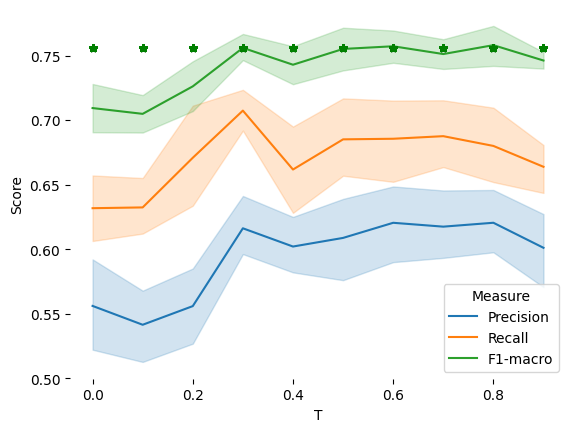

In [ ]:
ax = xmac.hypothesis_testing(ssize=200) # computed on dev
ax.get_figure().savefig("xmach_unimodal-eval.pdf", format="PDF", dpi=300);

In [ ]:
p, b, m = xmac.pvalue(th=0.8, ssize=500)
print(p)
print(f"{np.mean(m):.3f} compared to the baseline: {np.mean(b):.3f}")

MannwhitneyuResult(statistic=111.0, pvalue=0.008303805877402228)
0.775 compared to the baseline: 0.771


AUC: 0.623
              precision    recall  f1-score   support

       civil       0.46      0.52      0.49       356
         k+1       0.48      0.45      0.46       479
       toxic       0.38      0.36      0.37       165

    accuracy                           0.46      1000
   macro avg       0.44      0.44      0.44      1000
weighted avg       0.46      0.46      0.46      1000



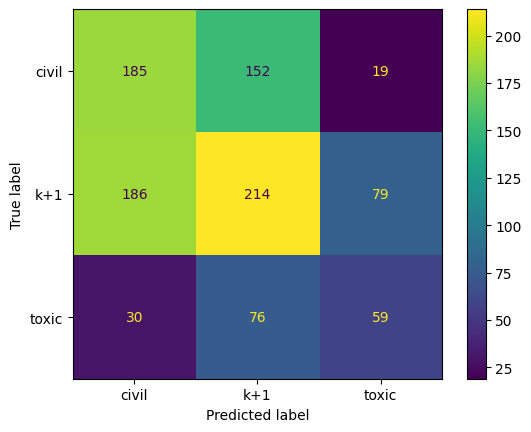

In [ ]:
# evaluate a 3-class model on all 3 classes
th = 0
target = xmac.test.apply(lambda x: xmac.labeller(x.DFU, x.toxicity_score, th), 1)
prediction = xmac.models[th].predict(xmac.to_np(xmac.test.bert))

predict_probs = xmac.models[th].predict_proba(xmac.to_np(xmac.test.bert))
print(f"AUC: {roc_auc_score(target, predict_probs, average='macro', multi_class='ovr'):.3f}")

print(classification_report(target, prediction))
cm = ConfusionMatrixDisplay.from_predictions(target, prediction);
cm.figure_.savefig("xmach-k+1.pdf", format="PDF", dpi=300)

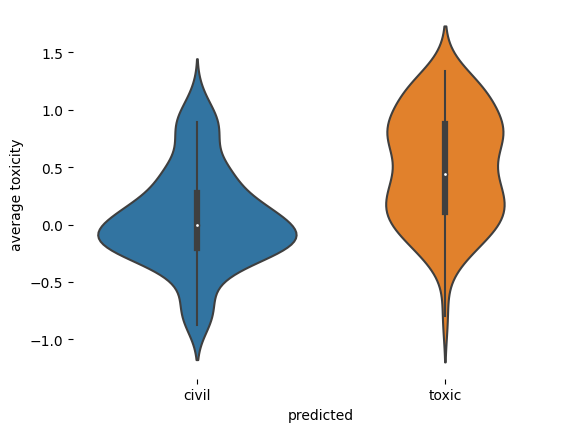

In [ ]:
err1 = xmac.test[(target=="k+1")&(prediction=="civil")] # +1 said civil
err2 = xmac.test[(target=="k+1")&(prediction=="toxic")] # +1 said toxic
ax = sns.violinplot(data=pd.DataFrame({"average toxicity":(-err1.toxicity_score.apply(np.mean)).to_list()+(-err2.toxicity_score.apply(np.mean)).to_list(),
                                       "predicted": ["civil"]*err1.shape[0] + ["toxic"]*err2.shape[0]
                                       }), y="average toxicity", x="predicted");
sns.despine(left=True, bottom=True)
ax.get_figure().savefig("xmac_violins.pdf", format="PDF", dpi=300)

In [ ]:
xmac.baseline_tuning()

{0.1: 0.7306034482758621,
 0.2: 0.7295039674737458,
 0.3: 0.7317892054734159,
 0.4: 0.7322025797417856,
 0.5: 0.7320794975645786,
 0.6: 0.7347660831520496,
 0.7: 0.7380070909482674,
 0.8: 0.7372883969041966,
 0.9: 0.7442006269592477}

# CCTK

In [ ]:
#@title [Optional] Develop the data
cctk_train = pd.read_csv("cctk_train.countries.csv.gz", parse_dates=["created_at"])
cctk_train.country = cctk_train.country.apply(literal_eval)
cctk_test = pd.read_csv("cctk_test.csv.gz", parse_dates=["created_at"])
cctk_dev = pd.read_csv("cctk_dev.csv.gz", parse_dates=["created_at"])

for dataset in (cctk_train, cctk_dev, cctk_test):
    dataset.scores = dataset.scores.apply(literal_eval)
    dataset.set_index("created_at", inplace=True)


# extract BERT features for train
embedded = []
for t in tqdm(cctk_train.text.values):
  try: embedded.append(bert_encode(t))
  except: embedded.append(None)
cctk_train.insert(3, "bert", embedded)
cctk_train.to_pickle("cctk_train_embedded.csv")

# extract BERT features for test
embedded = []
for t in tqdm(cctk_test.text.values):
  try: embedded.append(bert_encode(t))
  except: embedded.append(None)
cctk_test.insert(2, "bert", embedded)
cctk_test.to_pickle("cctk_test_embedded.csv")

# extract BERT features for dev (optional)
embedded = []
for t in tqdm(cctk_dev.text.values):
  try: embedded.append(bert_encode(t))
  except: embedded.append(None)
cctk_dev.insert(2, "bert", embedded)
cctk_dev.to_pickle("cctk_dev_embedded.csv")

from google.colab import drive
drive.mount('/content/drive')
!cp cctk_train_embedded.csv '/content/drive/MyDrive/4. Έρευνα/DFU/EMNLP/'
!cp cctk_test_embedded.csv '/content/drive/MyDrive/4. Έρευνα/DFU/EMNLP/'
!cp cctk_dev_embedded.csv '/content/drive/MyDrive/4. Έρευνα/DFU/EMNLP/'

In [19]:
#@title Download
%%capture
# RECALL TO UPLOAD THE DATA
# RECALL TO UPLOAD THE DATA
# RECALL TO UPLOAD THE DATA
cctk_train = pd.read_pickle("cctk_train_embedded.csv")
cctk_dev = pd.read_pickle("cctk_dev_embedded.csv")
cctk_test = pd.read_pickle("cctk_test_embedded.csv")

## Unimodal learning

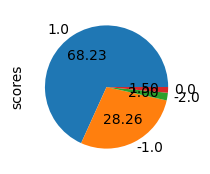

In [20]:
cctk_train.scores.explode().value_counts().plot.pie(figsize=(2,2), autopct=f'%.2f');

In [21]:
# computing nDFU for exploratory purposes later
cctk_train["HIST"] = cctk_train.scores.apply(lambda x: pdf(x, (-2, -1, 0, 1)))
cctk_train["DFU"] = cctk_train.HIST.apply(dfu)

In [22]:
# rejecting a bad data point
cctk_dev = cctk_dev[cctk_dev.bert.notna()]

In [23]:
xcctk = UnimodalLearner(cctk_train, cctk_dev, cctk_test, tox_threshold=0)

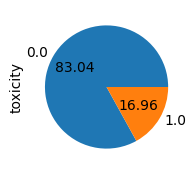

In [24]:
xcctk.train.toxicity.value_counts().plot.pie(figsize=(2,2), autopct=f'%.2f');

In [25]:
xcctk = UnimodalLearner(cctk_train, cctk_dev, cctk_test, tox_threshold=0)
xcctk.baseline_building()
xcctk.hypothesis_building()
xcctk.baseline_results

{'unimodal': {'P': 0.5932203389830508,
  'R': 0.3349282296650718,
  'F1': 0.706928238812773,
  'F1m': 0.9721394517282479,
  'AP': 0.4223172693795193,
  'AUC': 0.921630576097745,
  'support': 6712},
 'multimodal': {'P': 0.6334405144694534,
  'R': 0.17876588021778583,
  'F1': 0.5406984963852554,
  'F1m': 0.6899908731365987,
  'AP': 0.5246782563605872,
  'AUC': 0.7107485038644112,
  'support': 3287}}

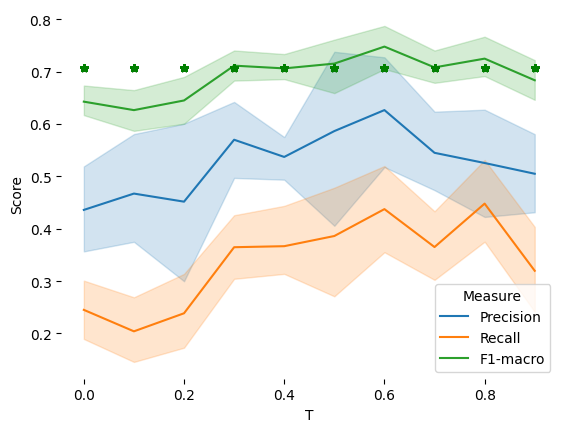

In [ ]:
ax = xcctk.hypothesis_testing();
ax.get_figure().savefig("cctk_unimodal-eval.pdf", format="PDF", dpi=300);

In [ ]:
p, b, m = xcctk.pvalue(th=0.6, ssize=2000)
print(p)
print(f"{np.mean(m):.2f} compared to the baseline: {np.mean(b):.2f}")

MannwhitneyuResult(statistic=100.0, pvalue=0.003555401038944634)
0.72 compared to the baseline: 0.71


AUC: 0.795
              precision    recall  f1-score   support

       civil       0.76      0.88      0.82      6065
         k+1       0.67      0.51      0.58      3619
       toxic       0.14      0.12      0.13       316

    accuracy                           0.72     10000
   macro avg       0.52      0.50      0.51     10000
weighted avg       0.71      0.72      0.71     10000



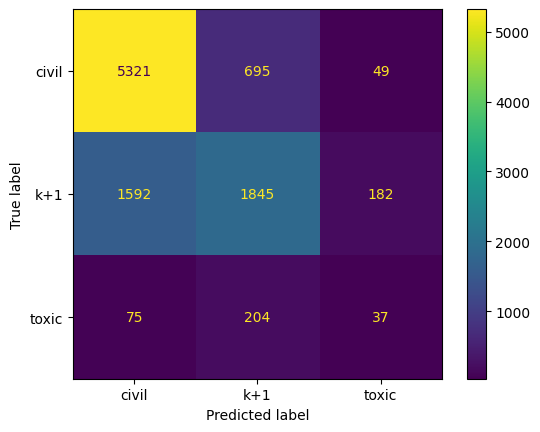

In [ ]:
# evaluate a 3-class model on all 3 classes
th = 0.
target = xcctk.test.apply(lambda x: xcctk.labeller(x.DFU, x.scores, th), 1)
prediction = xcctk.models[th].predict(xcctk.to_np(xcctk.test.bert))
predict_probs = xcctk.models[th].predict_proba(xcctk.to_np(xcctk.test.bert))
print(f"AUC: {roc_auc_score(target, predict_probs, average='macro', multi_class='ovr'):.3f}")

print(classification_report(target, prediction))
cm = ConfusionMatrixDisplay.from_predictions(target, prediction);
cm.figure_.savefig("cctk-k+1.pdf", format="PDF", dpi=300)

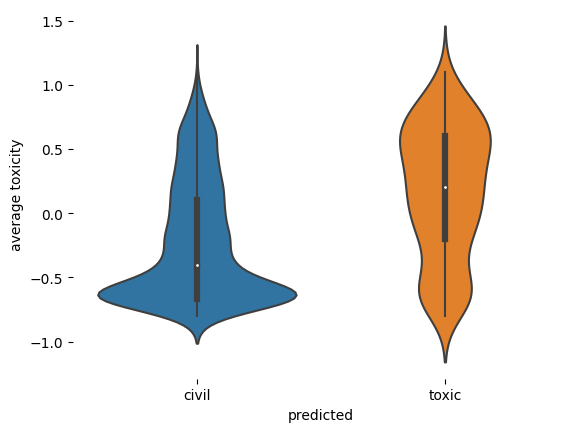

In [ ]:
err1 = xcctk.test[(target=="k+1")&(prediction=="civil")] # +1 said civil
err2 = xcctk.test[(target=="k+1")&(prediction=="toxic")] # +1 said toxic
ax = sns.violinplot(data=pd.DataFrame({"average toxicity":(-err1.scores.apply(np.mean)).to_list()+(-err2.scores.apply(np.mean)).to_list(),
                                       "predicted": ["civil"]*err1.shape[0] + ["toxic"]*err2.shape[0]
                                       }), y="average toxicity", x="predicted");
sns.despine(left=True, bottom=True)
ax.get_figure().savefig("xcctk_violins.pdf", format="PDF", dpi=300)

# Trained on CCTK, assessing on other datasets

In [ ]:
def pvalue(self, test, th=0, ssize=100, reps=range(20), averaging="macro"):
  model_results, baseline_results = [], []
  for _ in reps:
    e = test[test.DFU == 0].sample(ssize)
    probs = self.models[th].predict_proba(self.to_np(e["bert"]))[:, ::2] # ignoring K+1
    preds = np.argmax(probs, 1)
    baseline = self.baseline.predict(self.to_np(e["bert"]))
    model_results.append(f1_score(e.toxicity.values, preds, average=averaging))
    baseline_results.append(f1_score(e.toxicity.values, baseline, average=averaging))
  statistic = scipy.stats.mannwhitneyu(baseline_results, model_results, alternative="less")
  return statistic, baseline_results, model_results

In [ ]:
# attitudes
p, b, m = pvalue(xcctk, att_test, th=0.6, ssize=50)
print(f"{p}\nBaseline F1: {np.mean(b):.2f}±{np.std(b):.2f}\nUnimodal Learning: {np.mean(m):.2f}±{np.std(m):.2f}")

MannwhitneyuResult(statistic=142.0, pvalue=0.05969327464740423)
Baseline F1: 0.61±0.03
Unimodal Learning: 0.63±0.05


In [ ]:
# xmach
p, b, m = pvalue(xcctk, xm_test, th=0.6, ssize=500)
print(f"{p}\nBaseline F1: {np.mean(b):.2f}±{np.std(b):.2f}\nUnimodal Learning: {np.mean(m):.2f}±{np.std(m):.2f}")

MannwhitneyuResult(statistic=0.0, pvalue=3.345458297879516e-08)
Baseline F1: 0.68±0.00
Unimodal Learning: 0.72±0.00


# Investigating the support

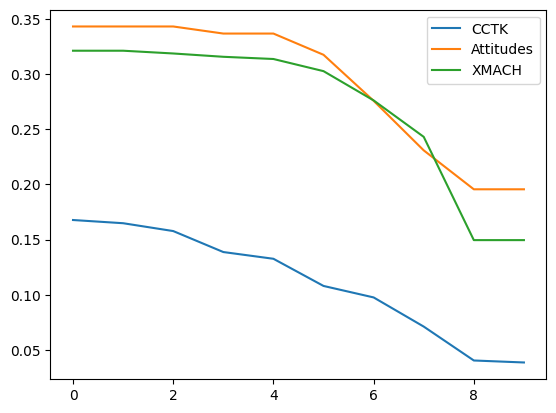

In [ ]:
support_pd = pd.DataFrame()
for corpus, name in ((xcctk, "CCTK"), (xattds, "Attitudes"), (xmac, "XMACH")):
  s = []
  for th in corpus.thresholds:
    target = corpus.train.apply(lambda x: corpus.labeller(x.DFU, x.toxicity, th), 1)
    s.append((target=="toxic").sum()/corpus.train.shape[0])
  support_pd[name] = s
support_pd.plot();

# Finding CCTK posts with (predicted) polarized opinions

In [ ]:
cctk_pred_pol = pd.DataFrame()
cctk_pred_pol["text"] = cctk_test.text
cctk_pred_pol["polarized"] = xcctk.models[0.6].predict_proba(xcctk.to_np(cctk_test.bert))[:, 1]
highly_polarized = cctk_pred_pol[cctk_pred_pol.polarized>0.5]
highly_polarized.sort_values(by="polarized", ascending=False).to_csv("cctk_predicted_polarized.csv", index=False)

# Exploratory

In [ ]:
xm_train["scores"] = xm_train["toxicity_score"]
#pd.DataFrame({"XMACH": xm_train.DFU, "Attitudes":att_train.DFU, "CCTK": cctk_train.DFU}).hist();
for name, dataset, text_col in (("CCTK", cctk_train, "text"), ("Attitudes", att_train, "tweet"), ("XMACH", xm_train, "comment")):
  print(f"{name}")
  print(f"# chars: {dataset[text_col].apply(len).mean():.2f} ({dataset[text_col].apply(len).std():.2f})")
  print(f"# instances: {dataset.shape[0]}")
  print(f"# codes: {dataset.scores.apply(len).mean():.2f} ({dataset.scores.apply(len).std():.2f})")

CCTK
# chars: 309.27 (276.60)
# instances: 10000
# codes: 6.14 (2.77)
Attitudes
# chars: 125.38 (85.90)
# instances: 313
# codes: 5.56 (0.78)
XMACH
# chars: 194.86 (128.31)
# instances: 2000
# codes: 8.41 (1.29)


<Axes: xlabel='age_group', ylabel='Count'>

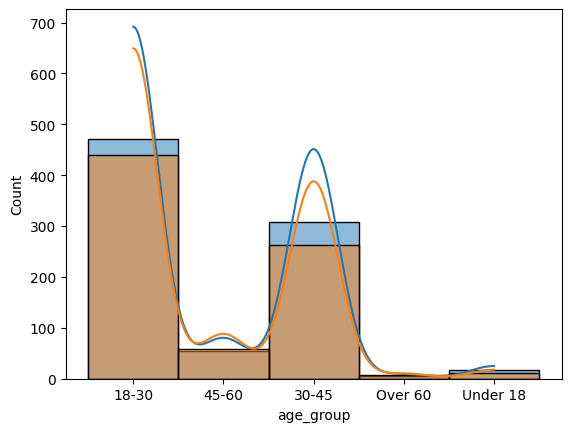

In [ ]:
fig, ax = plt.subplots()
x = xm_train[xm_train.DFU==0].sample(100).age_group.explode()
sns.histplot(x, ax=ax, kde=True, legend=True)
x = xm_train[xm_train.DFU>0.3].sample(100).age_group.explode()
sns.histplot(x, ax=ax, kde=True, legend=True)

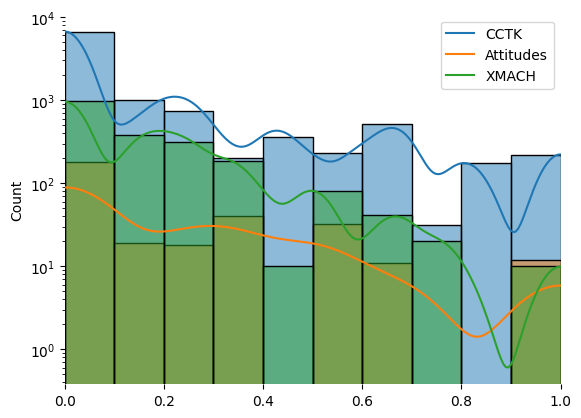

In [ ]:
fig, ax = plt.subplots()
labels = []
for name, a in (("CCTK", cctk_train), ("Attitudes", att_train), ("XMACH", xm_train)):
    sns.histplot(a.DFU, ax=ax, kde=True, bins=10, legend=True)
    ax.set_yscale('log')
    ax.set_xlabel("")
    labels.append(name)
plt.legend(labels=labels)
ax.set_xlim([0, 1])
sns.despine(bottom=True, left=True)
ax.get_figure().savefig("dfu_hists.pdf", format="PDF", dpi=300)

* Bias and polarization: Nothing regarding age

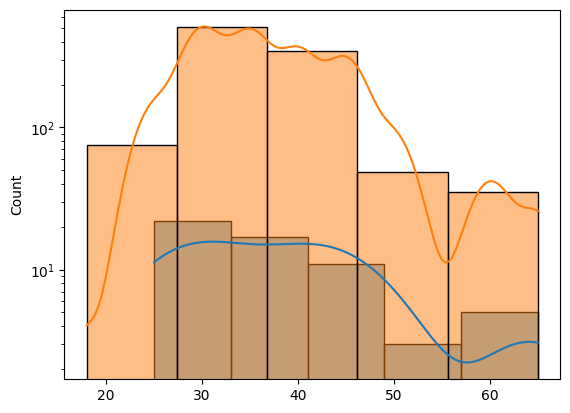

In [ ]:
fig, ax = plt.subplots()
sns.histplot(att_train[att_train.DFU>att_train.DFU.quantile(0.95)].annotatorAge.explode(), ax=ax, kde=True, bins=5)
sns.histplot(att_train[att_train.DFU==0].annotatorAge.explode(), ax=ax, kde=True, bins=5)
ax.set_xlabel("")
ax.set_yscale('log')

In [ ]:
#xm_train[['comment', 'toxicity', 'toxicity_score', 'gender', 'age_group', 'education', 'HIST', 'DFU', 'target', 'scores']].to_csv("xm_train.csv", index=False)
#cctk_train[['text', 'scores', 'country', 'HIST', 'DFU']].to_csv("cctk_train.csv", index=False)
#att_train[['tweet', 'toyou', 'toany', 'annotatorMinority', 'annotatorPolitics', 'traditionalism', 'annotatorRace', 'annotatorAge', 'annotatorGender', 'freeSpeech', 'harmHateSpeech', 'intent', 'lingPurism', 'racism', 'racist', 'scores', 'HIST', 'DFU', 'toxicity', 'target']].to_csv("att_train.csv", index=False)

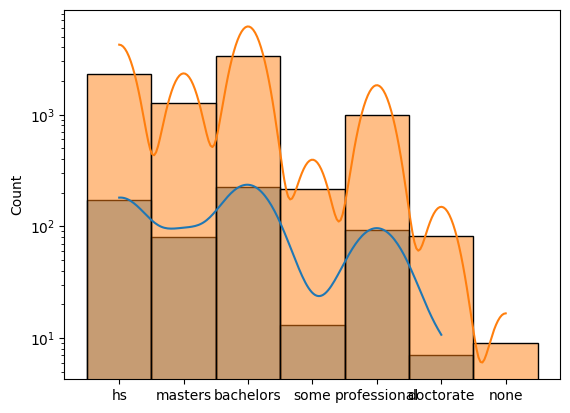

In [ ]:
fig, ax = plt.subplots()
sns.histplot(xm_train[xm_train.DFU>xm_train.DFU.quantile(0.95)].education.explode(), ax=ax, kde=True, bins=5)
sns.histplot(xm_train[xm_train.DFU==0].education.explode(), ax=ax, kde=True, bins=5)
ax.set_xlabel(""); ax.set_yscale('log')

# A posteriori unimodal: CCTK

In [ ]:
#@title [Optional] Develop the data
# RECALL TO UPLOAD THE DATA
!unzip jigsaw.zip
jigsaw = pd.read_csv('specialized_rater_pools_data.csv')
jigsaw = jigsaw[jigsaw.toxic_score.notna()] # some raters said 'not English'
jigsaw.sample()

# restructuring (one text to many annotations)
jigsaw_grouped = jigsaw.groupby('id')
jigsaw_grouped_pd = pd.DataFrame()
jigsaw_grouped_pd['scores'] = jigsaw_grouped.toxic_score.apply(list)
jigsaw_grouped_pd['text'] = jigsaw_grouped.comment_text.apply(lambda x: list(x)[0])
jigsaw_grouped_pd['group'] = jigsaw_grouped.rater_group.apply(list)

# extracting BERT features for this as well
embedded = []
for t in tqdm(jigsaw_grouped_pd.text.values):
  try: embedded.append(bert_encode(t))
  except: embedded.append(None)
jigsaw_grouped_pd.insert(3, "bert", embedded)
jigsaw_grouped_pd.to_pickle("jigsaw_embedded.csv")

  0%|          | 0/25500 [00:00<?, ?it/s]

In [ ]:
#@title Download
#@markdown A different sample of the CCTK dataset
# RECALL TO UPLOAD THE DATA
jigsaw_grouped_pd = pd.read_pickle('jigsaw_embedded.csv')
jigsaw_grouped_pd.sample()

Downloading...
From (uriginal): https://drive.google.com/uc?id=1J1xCq7SQ5hho-JD-jwLY3oBl_MwYYuFS
From (redirected): https://drive.google.com/uc?id=1J1xCq7SQ5hho-JD-jwLY3oBl_MwYYuFS&confirm=t&uuid=15881bcd-0177-4770-b870-0c97016cb4c3
To: /content/jigsaw_embedded.csv
100% 193M/193M [00:03<00:00, 60.5MB/s]


,scores,text,group,bert
id,,,,
312201,"[-1.0, -1.0, 1.0, -2.0, -2.0, -1.0, -1.0, -1.0...","Black Lives Matter!, wait then what about Red,...","[African American, African American, African A...","[0.12335708737373352, 0.1515430361032486, -0.0..."


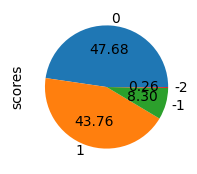

In [ ]:
# many 0s, compared to our previous sample
jigsaw_grouped_pd.scores.apply(np.mean).apply(round).value_counts().plot.pie(figsize=(2,2), autopct=f'%.2f');

In [ ]:
# not many in common with our CCTK sample
cctk_all = pd.concat([cctk_train, cctk_dev, cctk_test])
len(set(cctk_all.text.unique()).intersection(set(jigsaw_grouped_pd.text.unique())))

562

In [ ]:
# computing nDFU for exploratory purposes later
jigsaw_grouped_pd["HIST"] = jigsaw_grouped_pd.scores.apply(lambda x: pdf(x, (-2,-1, 0, 1)))
jigsaw_grouped_pd["DFU"] = jigsaw_grouped_pd.HIST.apply(dfu)

In [ ]:
coder_filter = lambda row, target='African American': [s for i,s in enumerate(row.scores) if row.group[i]==target]
t = 'African American'
aa_scores = jigsaw_grouped_pd.apply(lambda x: coder_filter(x, t), 1)
aa_len = aa_scores.apply(len)
aa_tox = aa_scores.apply(np.mean)
aa_dfu = aa_scores.apply(lambda x: dfu(pdf(x, (-2,-1, 0, 1))) if len(x)>1 else None)

In [ ]:
t = 'LGBTQ'
lgbtq_scores = jigsaw_grouped_pd.apply(lambda x: coder_filter(x, t), 1)
lgbtq_len = lgbtq_scores.apply(len)
lgbtq_tox = lgbtq_scores.apply(np.mean)
lgbtq_dfu = lgbtq_scores.apply(lambda x: dfu(pdf(x, (-2,-1, 0, 1))) if len(x)>1 else None)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [ ]:
t = 'Control'
cntr_scores = jigsaw_grouped_pd.apply(lambda x: coder_filter(x, t), 1)
cntrl_len = cntr_scores.apply(len)
cntrl_tox = cntr_scores.apply(np.mean)
cntrl_dfu = cntr_scores.apply(lambda x: dfu(pdf(x, (-2,-1, 0, 1))) if len(x)>1 else None)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [ ]:
pol = jigsaw_grouped_pd.DFU
aa_vs_cntrl = jigsaw_grouped_pd[(pol>0.5)&(aa_dfu==0)&(cntrl_dfu==0)&(abs(aa_tox-cntrl_tox)>2)]
print(aa_vs_cntrl.shape[0])
aa_vs_cntrl.sample()

6


,scores,text,group,bert,HIST,DFU
id,,,,,,
619729,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, -1.0, 1.0,...",Nothing in the Bible about Jesus saying anythi...,"[African American, African American, African A...","[-0.1304253339767456, 0.13434244692325592, 0.0...","[0.06666666666666667, 0.4, 0.06666666666666667...",0.714286


In [ ]:
lgbtq_vs_cntrl = jigsaw_grouped_pd[(pol>0.5)&(lgbtq_dfu==0)&(cntrl_dfu==0)&(abs(lgbtq_tox-cntrl_tox)>2)]
print(lgbtq_vs_cntrl.shape[0])
lgbtq_vs_cntrl.sample()

6


,scores,text,group,bert,HIST,DFU
id,,,,,,
974033,"[-1.0, 1.0, 1.0, -1.0, 1.0, -2.0, -1.0, -1.0, ...","Homosexuality, transgender sex-all are deviati...","[African American, African American, African A...","[-0.6162875294685364, 0.014585927128791809, -0...","[0.06666666666666667, 0.4, 0.0, 0.533333333333...",0.75


In [ ]:
aa_vs_lgbtq = jigsaw_grouped_pd[(pol>0.5)&(lgbtq_dfu==0)&(aa_dfu==0)&(abs(lgbtq_tox-aa_tox)>2)]
print(aa_vs_lgbtq.shape[0])
aa_vs_lgbtq.sample()

6


,scores,text,group,bert,HIST,DFU
id,,,,,,
6132927,"[1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -2.0, -1...","I want to see the so-called ""new Aryan Nation-...","[African American, African American, African A...","[0.09835062175989151, 0.17845037579536438, 0.0...","[0.13333333333333333, 0.3333333333333333, 0.06...",0.571429


In [ ]:
aa_vs_cntrl["poles"] = ["aa_vs_cntrl"]*aa_vs_cntrl.shape[0]
lgbtq_vs_cntrl["poles"] = ["lgbtq_vs_cntrl"]*lgbtq_vs_cntrl.shape[0]
aa_vs_lgbtq["poles"] = ["aa_vs_lgbtq"]*aa_vs_lgbtq.shape[0]
filtered = pd.concat([aa_vs_cntrl, lgbtq_vs_cntrl, aa_vs_lgbtq])
filtered.to_csv("jigsaw_aposteriori_unimodal.csv")

TXT: Nothing in the Bible about Jesus saying anything about immigration rights. Caiside, how many murders did illegal aliens commit in just California, in just this year? Just California. How many murders by illegal aliens? You answer that.
TXT: Are you high??? Selling someone a cake? Refusing to sell some a cake because it is for a gay wedding is no different from selling someone a cake because it is for a mixed race wedding or a Muslim wedding or any other kind of wedding. IT IS DISCRIMINATION! Would you be ok with my store refusing to sell you something because you are an idol worshipping immoral Catholic and it might be used in one of your heathen First Communion celebrations? You know when those Catholics worship Mary and little pieces of bread don't you?
TXT: In addition, AT, you are certainly a self-righteous hypocrite, but that in itself doesn't make you Christian, in fact it stands in the way of Christianity. You are like the Pharisees with their hateful dogma. In future, plea

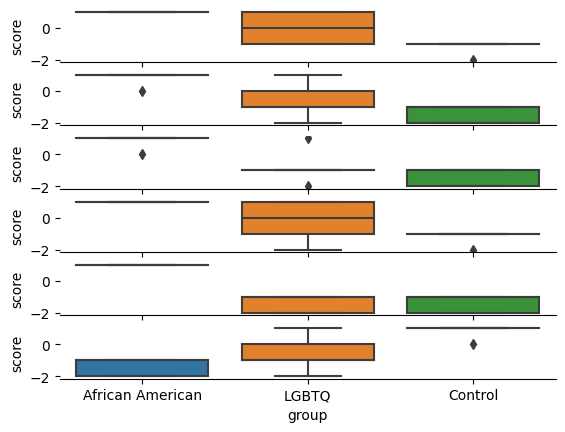

In [ ]:
pols = filtered[filtered.poles=='aa_vs_cntrl']
fig, axes = plt.subplots(nrows=pols.shape[0])
for i in range(pols.shape[0]):
  print(f'TXT: {" ".join(pols.iloc[i].text.split())}')
  sns.boxplot(pd.DataFrame({'score': pols.iloc[i].scores, 'group':pols.iloc[i].group}), y='score', x='group', ax=axes[i])
  sns.despine(left=True, bottom=False)
fig.savefig('aa_cnt.pdf', format='PDF', dpi=300)

TXT: They are words that were painted onto Jewish businesses in Nazi Germany (before the night when the store fronts of Jewish businesses were smashed) and that sent Jews and homosexuals to death camps. These same hate-inciting words we are seeing today being spray-painted onto some synagogues and mosques. You're not part of the solution, you're part of the problem.
TXT: Homosexuality, transgender sex-all are deviations from normal human behavior as well.
TXT: All men are sex offenders? Really? A sexual predator is a person who attacks a victim. Typical men don't rape or use force on women. You are obviously a person who hates men and or healthy, normal sex.
TXT: All speculation designed to convince the gullible that homosexual behaviour is perfectly normal and natural.
TXT: Women earned the vote by offending people, blacks earned a better place in the world by offending people, we earned basic human rights and shed the grip of the church and monarchs by offending people.
TXT: well tha

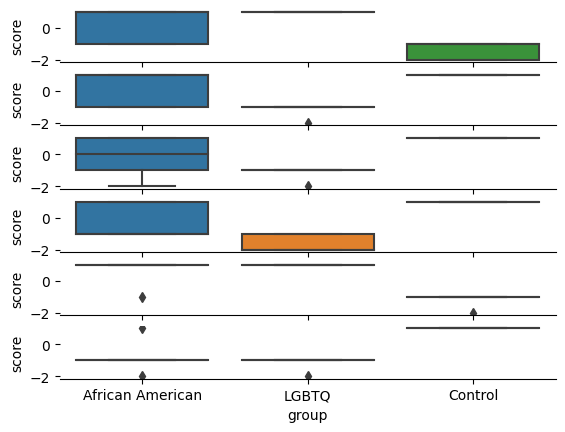

In [ ]:
pols = filtered[filtered.poles=='lgbtq_vs_cntrl']
fig, axes = plt.subplots(nrows=pols.shape[0])
for i in range(pols.shape[0]):
  print(f'TXT: {" ".join(pols.iloc[i].text.split())}')
  sns.boxplot(pd.DataFrame({'score': pols.iloc[i].scores, 'group':pols.iloc[i].group}), y='score', x='group', ax=axes[i])
  sns.despine(left=True)
fig.savefig('lgb_cnt.pdf', format='PDF', dpi=300)

TXT: the main issue is homegrown terrorist in the united states will now come out of the woodwork thank you Mr.Trump you really outdid yourself this time the White supremacist groups will use this tactic to there advantage like the KKK and Aryan nation and last but not least hell angels too. America has enough Terrorist living inside their borders to really cause lots of damage no need to the ban the people from the middle east and Africa the american people will wake up to attack from within their own borders and blame Muslim brother hoods and of course the American Black ganges too. Mr. Trump you have really gone and put your foot firmly in your Mouth sir shame Republicans will fill the heat now from all minority group from around the world not just Muslims or Somali groups and from India and Pakistan too.
TXT: No, homosexuals do not have a monopoly on pederasty. Pederasty is abuse, not consensual sex. It is rape.
TXT: Go back to whatever strange unicorn country you came from, please

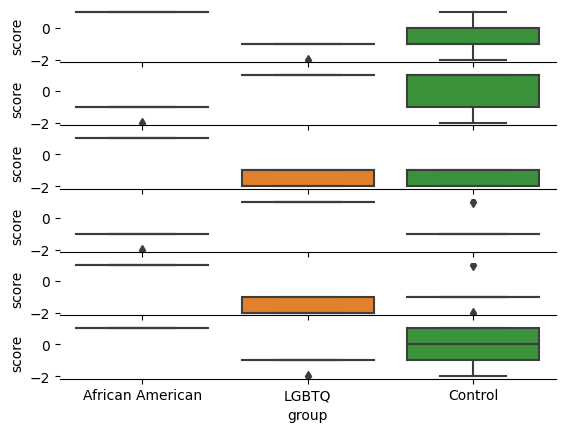

In [ ]:
pols = filtered[filtered.poles=='aa_vs_lgbtq']
fig, axes = plt.subplots(nrows=pols.shape[0])
for i in range(pols.shape[0]):
  print(f'TXT: {" ".join(pols.iloc[i].text.split())}')
  sns.boxplot(pd.DataFrame({'score': pols.iloc[i].scores, 'group':pols.iloc[i].group}), y='score', x='group', ax=axes[i])
  sns.despine(left=True)
fig.savefig('lgb_aa.pdf', format='PDF', dpi=300)

# A posteriori unimodal: Attitudes

In [ ]:
# RECALL TO UPLOAD THE DATA
attitudes = pd.read_pickle("attitudes_embedded.csv")
scale = list(range(1,6))
attitudes["scores"] = attitudes.toyou.apply(lambda x: [max(scale)+1-i for i in x]) # 5 should be civil (1 is toxic)
attitudes["HIST"] = attitudes.scores.apply(lambda x: pdf(x, scale))
attitudes["DFU"] = attitudes.HIST.apply(dfu) # scores.apply(np.var) / lambda x: random.random()

## Focus on gender

In [ ]:
high_pol = attitudes.DFU>0 # polarized
big_size = attitudes.annotatorGender.apply(len)==6 # enough votes
supported = attitudes.annotatorGender.apply(lambda x: (Counter(x)["woman"]>1) and (Counter(x)["man"]>1)) # both groups present
shortlist = attitudes[high_pol&big_size&supported]
shortlist.shape

(135, 19)

In [ ]:
dfu_gender = lambda row, gender="man", toxcol="toyou": dfu(pdf([row[toxcol][i] for i,g in enumerate(row.annotatorGender) if g==gender], scale))
x = shortlist[(shortlist.apply(lambda r: dfu_gender(r, "man"), 1)==0)&(shortlist.apply(lambda r: dfu_gender(r, "woman"), 1)==0)]
x

,tweet,toyou,toany,annotatorMinority,bert,annotatorPolitics,traditionalism,annotatorRace,annotatorAge,annotatorGender,freeSpeech,harmHateSpeech,intent,lingPurism,racism,racist,scores,HIST,DFU
93,Bitches be too mad bitch get some money and mo...,"[5, 5, 2, 4, 4, 1]","[5, 5, 3, 4, 4, 2]","[{}, {}, none, {}, {}, {}]","[0.2549588084220886, -0.04279607906937599, 0.2...","[-0.5, -1.0, -0.5, 0.5, -0.5, -1.0]","[4, 5, 2, 3, 5, 4]","[black, black, white, white, white, white]","[40.0, 25.0, 50.0, 35.0, 35.0, 25.0]","[woman, woman, man, woman, woman, man]","[1, 3, 1, 1, 1, 1]","[4, 5, 2, 5, 5, 4]","[5, 5, 3, 4, 4, 1]","[2, 5, 5, 5, 4, 5]","[1, 4, 3, 3, 1, 1]","[2, 3, 2, 3, 3, 1]","[1, 1, 4, 2, 2, 5]","[0.3333333333333333, 0.3333333333333333, 0.0, ...",0.500000
289,Keep in mind that sexual contact of any kind w...,"[2, 5, 5, 3, 5, 1]","[4, 5, 5, 5, 5, 2]","[NONE, immigrant, black,, {}, {}, bisexual, Ve...","[-0.23865552246570587, -0.010829821228981018, ...","[1.0, 0.0, 0.5, 0.5, -0.5, -1.0]","[3, 3, 5, 3, 3, 5]","[black, black, white, white, white, white]","[45.0, 35.0, 35.0, 45.0, 40.0, 35.0]","[man, woman, woman, man, woman, man]","[5, 1, 1, 4, 1, 1]","[4, 4, 4, 3, 5, 5]","[3, 5, 5, 3, 5, 1]","[3, 4, 5, 4, 5, 5]","[5, 1, 2, 3, 1, 5]","[4, 1, 3, 1, 1, 1]","[4, 1, 1, 3, 1, 5]","[0.5, 0.0, 0.16666666666666666, 0.166666666666...",0.333333
318,No clout. I WONT GIVE A RAT NO FAME I WON'T GI...,"[4, 4, 3, 2, 2, 2]","[4, 4, 2, 3, 2, 3]","[nan, {}, {}, {}, {}, {}]","[-0.21125884354114532, 0.3873864412307739, -0....","[-0.5, -0.5, 0.5, 0.5, -0.5, -0.5]","[3, 5, 2, 4, 4, 3]","[black, black, white, white, white, white]","[30.0, 30.0, 40.0, 35.0, 35.0, 45.0]","[man, man, man, woman, woman, woman]","[1, 1, 5, 1, 2, 1]","[3, 3, 2, 3, 3, 4]","[5, 4, 3, 2, 3, 2]","[5, 3, 5, 5, 4, 4]","[1, 1, 4, 1, 2, 1]","[1, 1, 1, 1, 1, 1]","[2, 2, 3, 4, 4, 4]","[0.0, 0.3333333333333333, 0.16666666666666666,...",0.333333
369,Sometimes I'll cut a jawn off just for being s...,"[4, 1, 4, 3, 2, 2]","[3, 1, 5, 4, 2, 3]","[nan, {}, {}, {}, {}, {}]","[0.22918452322483063, 0.273483544588089, -0.15...","[-0.5, -0.5, 0.5, 0.0, -0.5, -1.0]","[3, 5, 5, 5, 4, 1]","[black, black, white, white, white, white]","[30.0, 30.0, 40.0, 30.0, 35.0, 30.0]","[man, woman, man, man, woman, man]","[1, 1, 1, 2, 2, 1]","[3, 3, 5, 4, 3, 5]","[5, 1, 5, 3, 4, 5]","[5, 5, 5, 4, 4, 3]","[1, 2, 1, 3, 2, 1]","[1, 1, 1, 3, 1, 1]","[2, 5, 2, 3, 4, 4]","[0.0, 0.3333333333333333, 0.16666666666666666,...",0.500000
516,boy i've never been in a fight before but i fr...,"[4, 3, 3, 1, 3, 1]","[3, 3, 3, 2, 3, 3]","[nan, none, {}, {}, {}, bisexual]","[-0.011250785551965237, 0.03692465275526047, 0...","[-0.5, 0.0, 0.5, 0.5, -0.5, -0.5]","[3, 3, 5, 4, 3, 3]","[black, black, white, white, white, white]","[30.0, 30.0, 35.0, 35.0, 30.0, 40.0]","[man, man, man, woman, man, woman]","[1, 3, 1, 1, 1, 1]","[3, 2, 5, 3, 5, 5]","[2, 3, 5, 1, 2, 4]","[5, 5, 5, 5, 1, 5]","[1, 3, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1]","[2, 3, 3, 5, 3, 5]","[0.0, 0.16666666666666666, 0.5, 0.0, 0.3333333...",0.666667
556,let me tell you hey fuck you who ever made thi...,"[3, 2, 5, 5, 5, 5]","[4, 2, 4, 5, 5, 5]","[{}, {}, {}, None, immigrant, {}]","[-0.19164827466011047, 0.24510705471038818, 0....","[-0.5, -0.5, 0.5, 0.5, -0.5, -1.0]","[3, 3, 3, 4, 5, 4]","[black, black, white, white, white, white]","[35.0, 30.0, 35.0, 40.0, 40.0, 30.0]","[woman, woman, man, man, man, man]","[1, 1, 1, 2, 5, 3]","[4, 4, 4, 3, 5, 5]","[3, 2, 5, 4, 5, 5]","[3, 5, 5, 4, 5, 4]","[1, 1, 3, 2, 2, 1]","[3, 1, 5, 4, 5, 5]","[3, 4, 1, 1, 1, 1]","[0.6666666666666666, 0.0, 0.16666666666666666,...",0.250000


In [ ]:
x.tweet.iloc[1]

'Keep in mind that sexual contact of any kind with his "boyfriend" before admitting he was a tranny is literal rape.'

In [ ]:
x.to_excel('aposteriori_unimodal_attitudes.gender.xlsx')

## Focus on Race

In [ ]:
race_idx = {"black":1, "white":0, "na":-1, "native":-1}
big_size = attitudes.annotatorRace.apply(len)==6 # enough votes
supported = attitudes.annotatorRace.apply(lambda x: (Counter(x)["black"]>1) and (Counter(x)["white"]>1)) # both groups present
shortlist = attitudes[high_pol&big_size&supported]
shortlist.shape

(181, 19)

In [ ]:
dfu_condition = lambda row, key="black", toxcol="toyou", key_col='annotatorGender': dfu(pdf([row[toxcol][i] for i,g in enumerate(row[key_col]) if g==key], scale))
x = shortlist[(shortlist.apply(lambda r: dfu_condition(r, key="black", key_col='annotatorRace'), 1)==0)&(shortlist.apply(lambda r: dfu_condition(r, "white", key_col='annotatorRace'), 1)==0)]
x

,tweet,toyou,toany,annotatorMinority,bert,annotatorPolitics,traditionalism,annotatorRace,annotatorAge,annotatorGender,freeSpeech,harmHateSpeech,intent,lingPurism,racism,racist,scores,HIST,DFU
309,My mom so aggravating every time I like a car ...,"[4, 4, 2, 2, 1, 2]","[4, 5, 2, 2, 2, 2]","[{}, {}, {}, {}, {}, {}]","[0.09306392818689346, -0.14795063436031342, 0....","[-0.5, -1.0, 0.0, 0.5, -0.5, -0.5]","[4, 5, 5, 3, 5, 5]","[black, black, white, white, white, white]","[40.0, 25.0, 40.0, 35.0, 35.0, 35.0]","[woman, woman, woman, woman, woman, woman]","[1, 3, 1, 1, 1, 1]","[4, 5, 5, 5, 5, 5]","[4, 4, 2, 2, 2, 3]","[2, 5, 5, 5, 4, 4]","[1, 4, 1, 3, 1, 1]","[1, 3, 1, 1, 1, 1]","[2, 2, 4, 4, 5, 4]","[0.0, 0.3333333333333333, 0.0, 0.5, 0.16666666...",0.666667
318,No clout. I WONT GIVE A RAT NO FAME I WON'T GI...,"[4, 4, 3, 2, 2, 2]","[4, 4, 2, 3, 2, 3]","[nan, {}, {}, {}, {}, {}]","[-0.21125884354114532, 0.3873864412307739, -0....","[-0.5, -0.5, 0.5, 0.5, -0.5, -0.5]","[3, 5, 2, 4, 4, 3]","[black, black, white, white, white, white]","[30.0, 30.0, 40.0, 35.0, 35.0, 45.0]","[man, man, man, woman, woman, woman]","[1, 1, 5, 1, 2, 1]","[3, 3, 2, 3, 3, 4]","[5, 4, 3, 2, 3, 2]","[5, 3, 5, 5, 4, 4]","[1, 1, 4, 1, 2, 1]","[1, 1, 1, 1, 1, 1]","[2, 2, 3, 4, 4, 4]","[0.0, 0.3333333333333333, 0.16666666666666666,...",0.333333
342,Reminds me about a guy on 4chan who genuinely ...,"[4, 3, 4, 1, 1, 1]","[4, 3, 4, 1, 2, 2]","[{}, {}, {}, {}, Veteran, {}]","[-0.04991382732987404, -0.11697617918252945, -...","[-1.0, 0.0, 0.5, 0.0, -1.0, -0.5]","[5, 4, 5, 5, 5, 5]","[black, black, hisp, white, white, white]","[25.0, 35.0, 30.0, 40.0, 35.0, 35.0]","[woman, man, man, woman, man, woman]","[3, 1, 3, 1, 1, 1]","[5, 4, 5, 5, 5, 5]","[3, 2, 2, 1, 1, 1]","[5, 4, 4, 5, 5, 4]","[4, 1, 1, 1, 5, 1]","[5, 3, 4, 1, 1, 1]","[2, 3, 2, 5, 5, 5]","[0.0, 0.3333333333333333, 0.16666666666666666,...",0.333333
357,Sick to death of either seein nobs or ur minge...,"[5, 5, 3, 2, 2, 3]","[5, 5, 3, 3, 2, 3]","[{}, {}, none, {}, {}, {}]","[-0.042324356734752655, 0.20226505398750305, -...","[-0.5, 0.0, -0.5, 0.0, -0.5, -1.0]","[4, 5, 2, 2, 2, 4]","[black, black, white, white, white, white]","[40.0, 45.0, 50.0, 35.0, 40.0, 25.0]","[woman, man, man, man, man, man]","[1, 1, 1, 3, 1, 1]","[4, 5, 2, 2, 4, 4]","[4, 5, 2, 2, 3, 3]","[2, 4, 5, 3, 5, 5]","[1, 1, 3, 1, 1, 1]","[1, 5, 1, 1, 1, 1]","[1, 1, 3, 4, 4, 3]","[0.3333333333333333, 0.0, 0.3333333333333333, ...",1.000000
364,So can we just stop saying there is no racism ...,"[5, 4, 2, 5, 5, 4]","[5, 4, 4, 5, 5, 5]","[Black american, {}, {}, {}, {}, {}]","[-0.12828494608402252, 0.061020202934741974, 0...","[-0.5, -0.5, 0.0, 0.5, -1.0, -1.0]","[5, 3, 5, 4, 4, 5]","[black, black, other, white, white, white]","[30.0, 30.0, 55.0, 35.0, 30.0, 45.0]","[man, woman, man, woman, man, woman]","[1, 1, 2, 1, 3, 1]","[5, 4, 5, 5, 5, 5]","[5, 4, 2, 5, 5, 3]","[5, 5, 5, 5, 4, 5]","[5, 1, 2, 1, 1, 1]","[5, 2, 2, 5, 5, 3]","[1, 2, 4, 1, 1, 2]","[0.5, 0.3333333333333333, 0.0, 0.1666666666666...",0.333333
423,This raghead colleague is such a traitor!,"[3, 3, 5, 5, 5, 5]","[3, 3, 3, 5, 2, 5]","[Black american, {}, {}, {}, {}, nan]","[0.04868575558066368, 0.5501320958137512, -0.1...","[-0.5, -0.5, 0.5, 0.5, -1.0, -1.0]","[5, 3, 3, 4, 2, 5]","[black, black, white, white, white, white]","[30.0, 30.0, 35.0, 35.0, 35.0, 45.0]","[man, woman, man, woman, woman, woman]","[1, 1, 1, 1, 1, 1]","[5, 4, 4, 5, 5, 5]","[3, 4, 4, 5, 5, 5]","[5, 5, 5, 5, 4, 3]","[5, 1, 3, 1, 1, 1]","[1, 4, 4, 4, 5, 5]","[3, 3, 1, 1, 1, 1]","[0.6666666666666666, 0.0, 0.3333333333333333, ...",0.500000
546,"imagine being such absolute scum, I want those...","[5, 5, 4, 1, 5, 5]","[5, 5, 5, 2, 5, 5]","[{}, {}, nan, {}, {}, {}]","[0.3449878394603729, 0.44626960158348083, 0.12...","[-1.0, 0.0, 1.0, 0.5, -0.5, -0.5]","[5, 4, 3, 5, 5, 3]","[black, black, white, hisp, white, white]","[25.0, 35.0, 35.0, 30.0, 35.0, 45.0]","[woman, man, man, man, woman, woman]","[3, 1, 5, 3, 1, 2]","[5, 4, 1, 5, 5, 3]

In [ ]:
x.to_excel('aposteriori_unimodal_attitudes.race.xlsx')

## Showcase

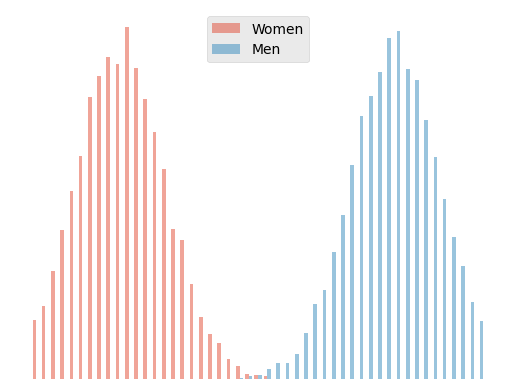

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')

fig=plt.figure()
x = np.random.normal(2, 1, 10000)
y = np.random.normal(8, 1, 10000)
bins = np.linspace(0, 10, 50);
plt.hist([x, y], bins, label=['Women', 'Men'], alpha=0.5, density=True);
plt.legend();
plt.axis('off');
sns.despine(bottom=True)
fig.savefig("aposteriori_unimodal.pdf", format="PDF", dpi=300)

# Explanations

In [ ]:
%%capture
!pip install lime
from lime.lime_text import LimeTextExplainer

In [ ]:
to_explain = xcctk.test[(target=="k+1")&(prediction=="toxic")]
text = to_explain.sample().text.item()
print(text)

'I'm not black, but there's a whole lotta times I wish I could say I'm not white.'
  - frank zappa


In [ ]:
def xmodel(texts, th=0):
  encoded = [bert_encode(t) for t in tqdm(texts)]
  encoded = np.array(encoded).reshape(len(texts), 768)
  return xcctk.models[th].predict_proba(encoded)

explainer = LimeTextExplainer(class_names = list(xcctk.models[0].classes_))
exp = explainer.explain_instance(text, xmodel, num_features=6, num_samples=50, labels=[1])
exp.show_in_notebook(text=True)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
from joblib import dump, load
dump(xcctk.models[0.3], 'cctk03.joblib')

In [ ]:
!zip pdfs.zip *.pdf
!zip csvs.zip *.csv